In [87]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# **Step 1: Data Cleaning & Feature Engineering**

In [88]:
import pandas as pd
import numpy as np
import datetime as datetime

file_path = '/content/drive/MyDrive/Data Science Projects/Classification of Customer Personality/marketing_campaign.csv'

# 1) Load the dataset
data = pd.read_csv(file_path, sep='\t');
df = data.copy()
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


# Details about Column Names

## _People_

* **ID** - Customer’s unique identifier;
* **Year_Birth** - Customer's birth year;
* **Education** - Education Qualification of customer;
* **Marital_Status** - Marital Status of customer;
* **Income** - Customer's yearly household income;
* **Kidhome** - Number of children in customer's household;
* **Teenhome** - Number of teenagers in customer's household;
* **Dt_Customer** - Date of customer's enrollment with the company;
* **Recency** - Number of days since customer's last purchase;

## _Products_

* **MntWines** - Amount spent on wine in last 2 years
* **MntFruits** - Amount spent on fruits in last 2 years
* **MntMeatProducts** - Amount spent on meat in last 2 years
* **MntFishProducts** - Amount spent on fish in last 2 years
* **MntSweetProducts** - Amount spent on sweets in last 2 years
* **MntGoldProds** - Amount spent on gold in last 2 years

## _Promotion_

* **NumDealsPurchases** - Number of purchases made with a discount
* **AcceptedCmp1** - 1 if customer accepted the offer in the 1st campaign, 0 otherwise
* **AcceptedCmp2** - 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
* **AcceptedCmp3** - 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
* **AcceptedCmp4** - 1 if customer accepted the offer in the 4th campaign, 0 otherwise
* **AcceptedCmp5** - 1 if customer accepted the offer in the 5th campaign, 0 otherwise
* **Response** - 1 if customer accepted the offer in the last campaign, 0 otherwise

# _Place_

* **NumWebPurchases** - Number of purchases made through the company’s website
* **NumCatalogPurchases** - Number of purchases made using a catalogue
* **NumStorePurchases** - Number of purchases made directly in stores
* **NumWebVisitsMonth** - Number of visits to company’s website in the last month

In [89]:
# 2) Handle Missing Values
df['Income']=df['Income'].fillna(df['Income'].median())
# 3) Drop Zero Columns
df = df.drop(columns=['Z_CostContact', 'Z_Revenue'])
# 4) Feature Engineering
df['Age'] = 2014 - df['Year_Birth']

# Calculate Toltal Amount Spent
df['Total_Spent'] = (df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] +
                     df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds'])

# Calculate Total Childer
df['Total_Children'] = df['Kidhome'] + df['Teenhome']

# Calculate Customer Tenure in Days
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')

# Calculate days since they became a customer relative to the new customer in the dataset
most_recent_date = df['Dt_Customer'].max()
df['Customer_Days'] = (most_recent_date - df['Dt_Customer']).dt.days

#Combine martial statuses into into simpler Categories
df['Marital_Status'] = df['Marital_Status'].replace(
    {'Married': 'Partner',
     'Together': 'Partner',
     'Absurd': 'Single',
     'Widow': 'Single',
     'YOLO': 'Single',
     'Divorced': 'Single'}
)

# 5) Drop anomalies
df = df[df['Age'] < 100]

print(df[['Age', 'Income', 'Total_Spent', 'Total_Children', 'Customer_Days']].head())
print(f"\nFinal dataset shape: {df.shape}")

   Age   Income  Total_Spent  Total_Children  Customer_Days
0   57  58138.0         1617               0            663
1   60  46344.0           27               2            113
2   49  71613.0          776               0            312
3   30  26646.0           53               1            139
4   33  58293.0          422               1            161

Final dataset shape: (2237, 31)


# **Step 2: EDA, Probability & Statistics**

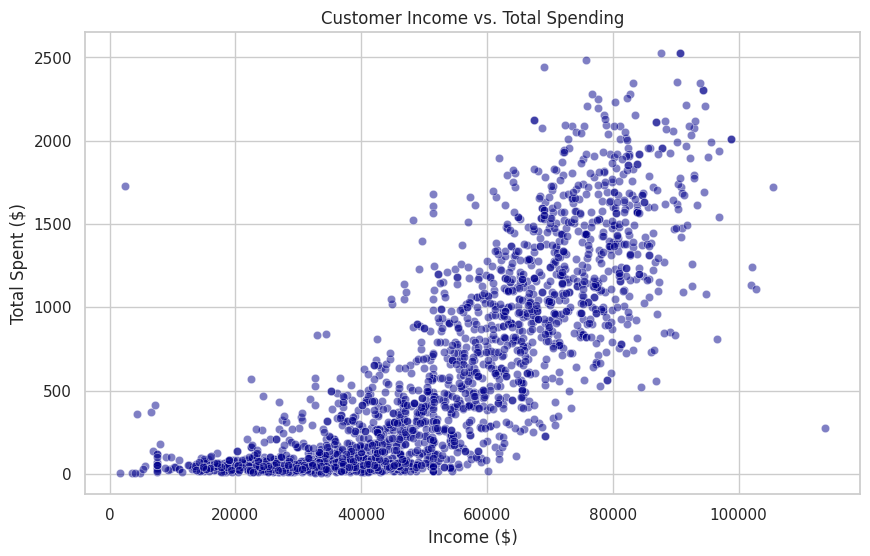

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')

# 1) The Relationship (Higher Income => Higher Spending?)
plt.figure(figsize=(10, 6))
# Limit x to 150000 to ignore outliers
sns.scatterplot(data=df[df['Income'] < 150000], x='Income', y='Total_Spent', alpha=0.5, color='darkblue')
plt.title('Customer Income vs. Total Spending')
plt.xlabel('Income ($)')
plt.ylabel('Total Spent ($)')
plt.show()

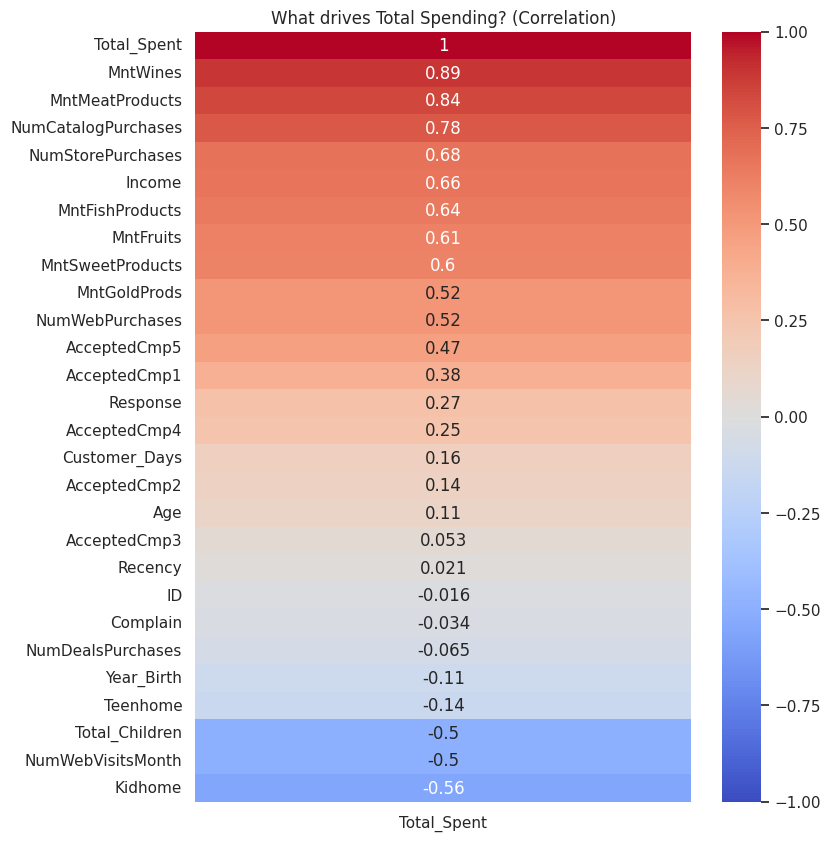

In [91]:
# 2) The Statistical Heatmap (Correlation)
# Which factor mathematically drive spending? In here - Pearson Correlation (-1,1)
plt.figure(figsize=(8, 10))
numeric_df = df.select_dtypes(include=['int64', 'float64', 'int32'])
corr_matrix = numeric_df.corr()

# Main Targer - Correlation of 'Total Spent'
spent_corr = corr_matrix[['Total_Spent']].sort_values(by='Total_Spent', ascending=False)

sns.heatmap(spent_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('What drives Total Spending? (Correlation)')
plt.show()

In [92]:
# 3) Probability & Group Statistics
#Business Question: How does having children impact luxury purchases (like wine)?
kids_impact = df.groupby('Total_Children')[['Total_Spent', 'MntWines', 'NumDealsPurchases']].mean().round(2)

print('Average Customer Behaviour based on Number of Children:')
print(kids_impact)

Average Customer Behaviour based on Number of Children:
                Total_Spent  MntWines  NumDealsPurchases
Total_Children                                          
0                   1104.86    486.89               1.14
1                    473.50    267.49               2.47
2                    245.95    141.59               3.56
3                    274.60    171.38               3.79


# **Step 3: Unsupervised Machine Learning**

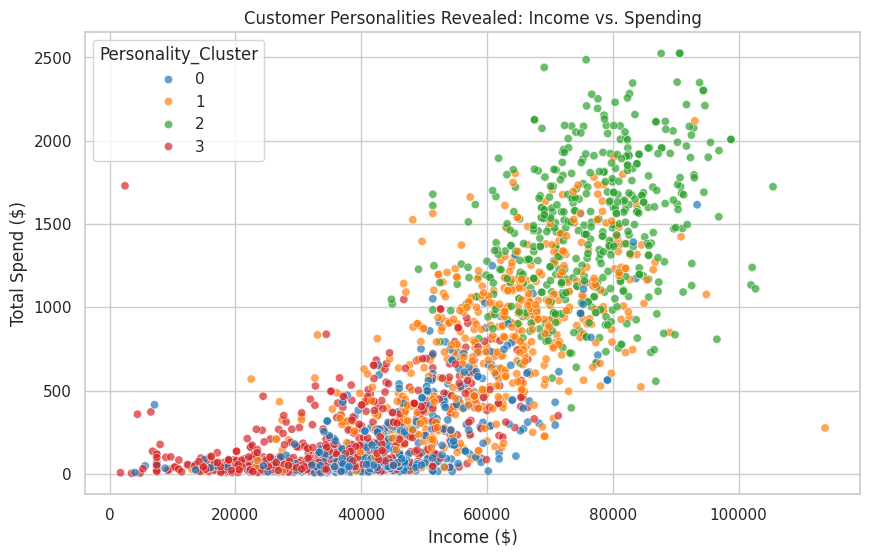

In [93]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 1) Prepare and Scale the Data
# Important Features to Define a "Personality"
features = ['Income', 'Total_Spent', 'Age', 'Total_Children']
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2) Applying K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df['Personality_Cluster'] = kmeans.fit_predict(X_scaled)

# 3) Visualising the Personalities
plt.figure(figsize=(10, 6))
sns.scatterplot(data = df[df['Income'] < 150000],
                x = 'Income', y = 'Total_Spent',
                hue = 'Personality_Cluster', palette='tab10', alpha=0.7)
plt.title('Customer Personalities Revealed: Income vs. Spending')
plt.xlabel('Income ($)')
plt.ylabel('Total Spend ($)')
plt.show()

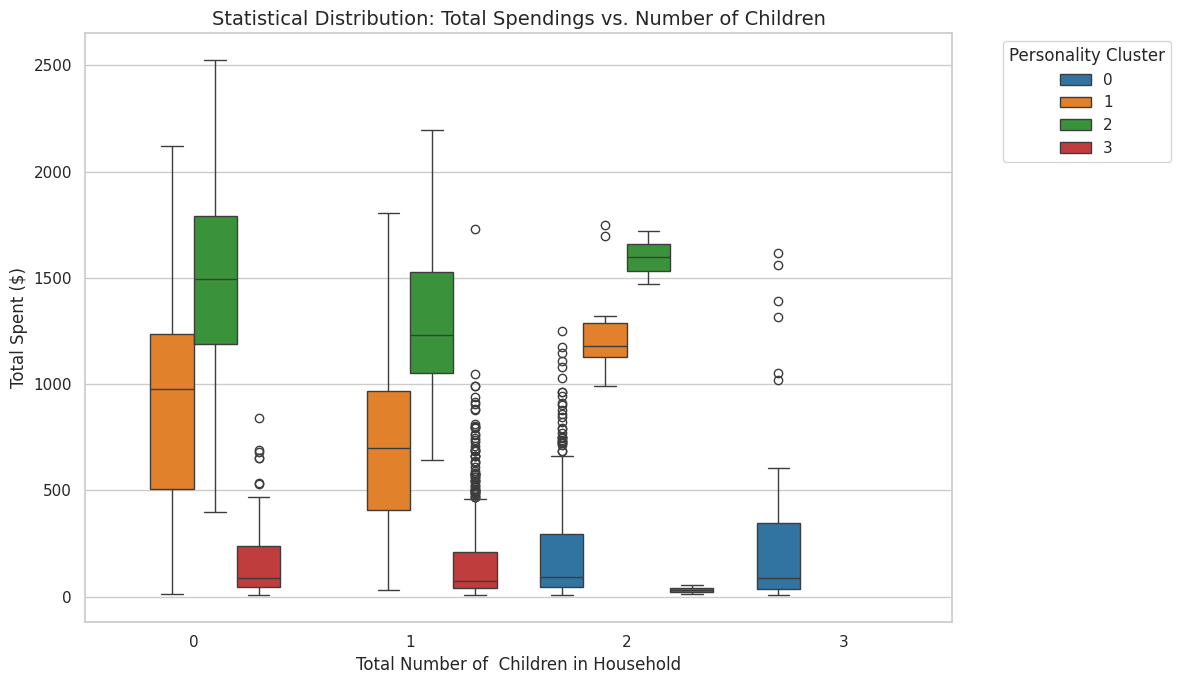

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))

sns.boxplot(data=df[df['Income'] < 150000],
              x = 'Total_Children',
              y = 'Total_Spent',
              hue = 'Personality_Cluster',
              palette = 'tab10',)

plt.title('Statistical Distribution: Total Spendings vs. Number of Children', fontsize=14)
plt.xlabel('Total Number of  Children in Household', fontsize=12)
plt.ylabel('Total Spent ($)', fontsize=12)

plt.legend(title='Personality Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [95]:
# 4) The Business Value (Profiling)
cluster_profile = df.groupby('Personality_Cluster')[['Income', 'Total_Spent', 'Age', 'Total_Children']].mean().round(1)
#The Number of People in Each Group
cluster_profile['Number_of_Clusters'] = df['Personality_Cluster'].value_counts()

print("\n--- The 4 Customer Personalities ---")
print(cluster_profile)


--- The 4 Customer Personalities ---
                      Income  Total_Spent   Age  Total_Children  \
Personality_Cluster                                               
0                    44108.5        222.8  48.6             2.1   
1                    60430.7        770.0  57.2             0.7   
2                    78130.9       1435.8  40.4             0.3   
3                    33797.9        167.4  36.8             0.9   

                     Number_of_Clusters  
Personality_Cluster                      
0                                   458  
1                                   560  
2                                   487  
3                                   732  


# **Step 4: Supervised Machine Learning (Predictive Analytics)**

---AI Preformance Report---
              precision    recall  f1-score   support

           0       0.87      0.97      0.91       376
           1       0.57      0.24      0.33        72

    accuracy                           0.85       448
   macro avg       0.72      0.60      0.62       448
weighted avg       0.82      0.85      0.82       448



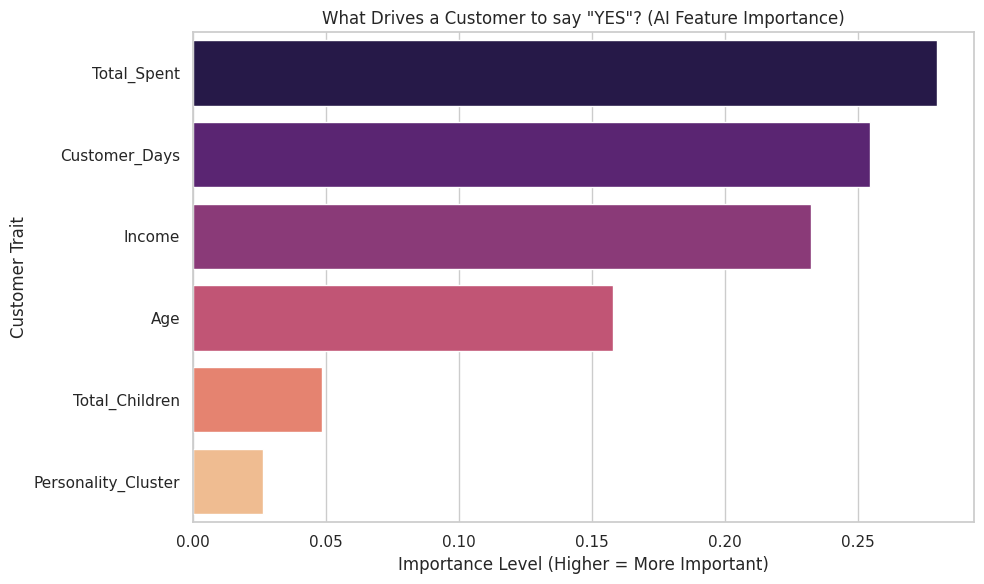

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1) Selecting the Features and Target
features = ['Income', 'Total_Spent', 'Age', 'Total_Children', 'Customer_Days', 'Personality_Cluster']

X = df[features]
y = df['Response']

# 2) Train and Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3) Train the Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)
# 4) Prediction & Evaluation
y_pred = rf_model.predict(X_test)

print("---AI Preformance Report---")
print(classification_report(y_test, y_pred))

# 5) Feature Importance
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Visualising the AI's "Brain"
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='magma')
plt.title('What Drives a Customer to say "YES"? (AI Feature Importance)')
plt.xlabel('Importance Level (Higher = More Important)')
plt.ylabel('Customer Trait')
plt.tight_layout()
plt.show()

# **Step 5: Model Optimisation**

Original Training Data: 262 Buyers vs 1527 Non-Buyers
SMOTE Training Data:    1527 Buyers vs 1527 Non-Buyers
--------------------------------------------------
Optimized AI Performance Report
              precision    recall  f1-score   support

           0       0.91      0.73      0.81       376
           1       0.31      0.64      0.42        72

    accuracy                           0.72       448
   macro avg       0.61      0.69      0.62       448
weighted avg       0.82      0.72      0.75       448



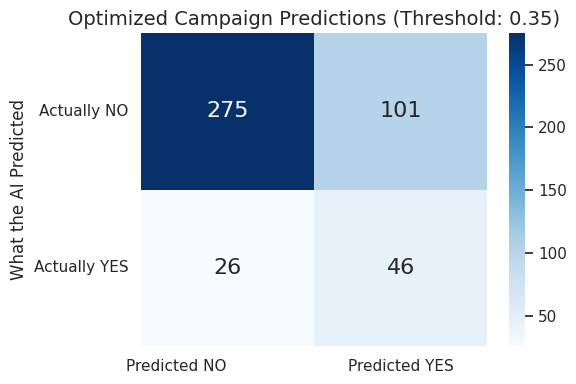

In [98]:
!pip install imbalanced-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
# Importing SMOTE (Synthetic Minority Over-sampling Technique)
from imblearn.over_sampling import SMOTE

# 1) The SMOTE Data Augmentation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Original Training Data: {sum(y_train==1)} Buyers vs {sum(y_train==0)} Non-Buyers")

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"SMOTE Training Data:    {sum(y_train_smote==1)} Buyers vs {sum(y_train_smote==0)} Non-Buyers")
print("-" * 50)

# 2) Train the Supercharged AI
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote.fit(X_train_smote, y_train_smote)

# 3) The Custom Threshold
probabilities = rf_smote.predict_proba(X_test)[:, 1]
custom_threshold = 0.35
y_pred_optimized = (probabilities >= custom_threshold).astype(int)

print("Optimized AI Performance Report")
print(classification_report(y_test, y_pred_optimized))

# Generating Confusion Matrix
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred_optimized)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.title(f'Optimized Campaign Predictions (Threshold: {custom_threshold})', fontsize=14)
plt.ylabel('What Actually Happened (Truth)', fontsize=12)
plt.ylabel('What the AI Predicted', fontsize=12)

plt.xticks(ticks=[0.2, 1.5], labels=['Predicted NO', 'Predicted YES'])
plt.yticks(ticks=[0.5, 1.5], labels=['Actually NO', 'Actually YES'], rotation=0)
plt.tight_layout()
plt.show()